# lab 7

# Supermodeling

## What is supermodeling

![](images/architecture.png)

source: Complex Systems Lecture

## Submodels

![](images/like_neuron.png)

source: Complex Systems Lecture

![](images/explanation.png)

source: Complex Systems Lecture

![](images/coupling.png)

source: Complex Systems Lecture

## Lorenz again

![Lorenz equations](images/lorenz.png)

source: https://en.wikipedia.org/wiki/Lorenz_system

### Utilities

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from math import ceil
from data_assimilation import assimilate_lorenz, assimilate_lorenz_weighted
%matplotlib inline

In [4]:
def plot_models(models, timelines=None, figsize=(8,8)):
    fig = plt.figure(figsize=figsize)
    ax = fig.gca(projection="3d")
    for piece in models:
            ax.plot(piece[:, 0].flatten(), piece[:, 1].flatten(), piece[:, 2].flatten(), lw=0.5)
    plt.draw()
    plt.show()
    
    if timelines:
        plot_models_coords_in_time(models, timelines)
    
def plot_model(model, timeline=None, figsize=(5,5)):
    plot_models([model], figsize=figsize)
    if timeline is not None:
        plot_model_coords_in_time(model, timeline)

    
def calc_mean_lorenz(lorenz_models):
    return np.array([np.mean(lorenz_models[:,i,:], axis=0) for i in range(lorenz_models.shape[1])])


def calc_weighted_average_lorenz(lorenz_models, weights):
    return np.array([np.average(lorenz_models[:,i,:], axis=0, weights=weights) for i in range(lorenz_models.shape[1])])

def lorenz_step(coords, parameters, dt=0.01):
    rho, sigma, beta = parameters
    x, y, z = coords
    return coords + (np.array([sigma * (y - x), x * (rho - z) - y, x * y - beta * z]) * dt)

def generate_lorenz(x=1, y=1, z=1, sigma=10.0, rho=28.0, beta=8.0/3.0, start_time=0.0, number_of_samples=4000, dt=0.01, plot=False):
    size = number_of_samples
    
    if start_time:
        size += ceil(start_time/dt)

    coords = np.empty([size,3])

    coords[0] = [x,y,z]
    parameters = [rho, sigma, beta]
    for i in range(size - 1):
        coords[i+1] = lorenz_step(coords[i],parameters, dt=dt)
    coords= coords[-number_of_samples:]
    if plot:
        plot_model(coords)
    return coords, np.arange(start_time, start_time + number_of_samples * dt, dt)

def plot_models_coords_in_time(models, timelines):
    f, (px, py, pz) = plt.subplots(3, 1, sharex=True, figsize=(15,8))

    px.set_ylabel("X component")
    py.set_ylabel("Y component")
    pz.set_ylabel("Z component")
    
    for ix, (model, timeline) in enumerate(zip(models, timelines)):
        px.plot(timeline, model[:,0], lw=0.5)
        py.plot(timeline, model[:,1], lw=0.5)
        pz.plot(timeline, model[:,2], lw=0.5, label=str(ix+1))

    pz.set_xlabel("Time index (x 100)")
    
    f.legend(title="Models in order")
    

def plot_model_coords_in_time(model, timeline):
    plot_models_coords_in_time([model], [timeline])
    
def lorenz_research(
    start_time = 4.5,
    number_of_samples = 200,
    steps_4dvar = 20,
    small_plot = True,
    full_plot = True,
    initial_params = None
):
    l63_gt, l63_timeline_gt = generate_lorenz(
        start_time=start_time, 
        number_of_samples=number_of_samples
    )
    
    
    initial = dict(
        x=l63_gt[0][0], 
        y=l63_gt[0][1],
        z=l63_gt[0][2],
        sigma = 10.0,
        rho = 20.,
        beta = 5.
    )
    
    if initial_params is not None:
        initial.update(initial_params)
    
    error_vector = [0.1, 0.1, 0.1, 100, 100, 100]
    
    coords_and_params = assimilate_lorenz(
        initial, 
        l63_gt,
        lorenz_step, 
        maximum_number_of_steps=steps_4dvar,
        verbose=True, 
        error_vector=error_vector
    )
    l63_4dv, l63_4dv_timeline = generate_lorenz(
        x=l63_gt[0][0], 
        y=l63_gt[0][1],
        z=l63_gt[0][2],
        sigma=coords_and_params['sigma'],
        rho=coords_and_params['rho'],
        beta=coords_and_params['beta'],
        number_of_samples=number_of_samples
    )
    
    print(l63_gt, l63_timeline_gt)
    
    if small_plot:
        plot_models(
            [l63_gt, l63_4dv],
            [l63_timeline_gt, l63_timeline_gt]
        )
    
    
    full_lorenz, fl_timeline = generate_lorenz()
    full_predicted, full_pred_timeline = generate_lorenz(sigma=coords_and_params['sigma'],rho=coords_and_params['rho'],beta=coords_and_params['beta'])
        
    if full_plot:
        plot_models([full_lorenz, full_predicted], [fl_timeline, full_pred_timeline])
        
    return {
        'partial': {
            'gt': [l63_gt, l63_timeline_gt],
            'pred': [l63_4dv, l63_4dv_timeline],
        },
        'full': {
            'gt': [full_lorenz, fl_timeline],
            'pred': [full_predicted, full_pred_timeline],
        }
    }

def set_submodel_consts(
    number_of_samples = 200,
    steps_4dvar = 20
):    
    def create_submodel(sigma, rho, beta, start_time = 4.5):
            
        return lorenz_research(    
            start_time = start_time,
            number_of_samples = number_of_samples,
            steps_4dvar = steps_4dvar,
            small_plot = True,
            full_plot = False,
            initial_params = dict(sigma=sigma,rho=rho,beta=beta)
        )

    return create_submodel

## Task 1. Choose a fragment of Lorenz 63

In the first task you have to sample a chosen part of Lorenz attractor.
Remember that the attractor uses time so in other word `models_start` variable is a time from which we start sampling.
Keep in mind that `number_of_samples = 200` is maximum value for reasonably timed computation in future tasks, do don't change it.

In [10]:
# TODO: find fancy, not too long trajectory of L63
model_start = ??

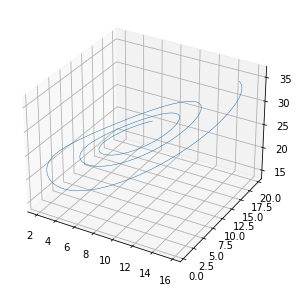

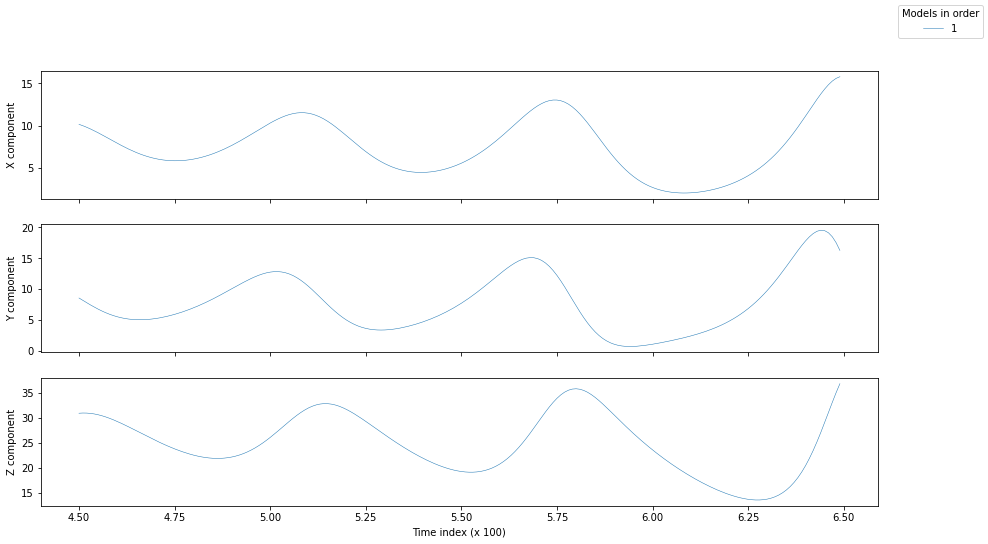

In [11]:
l63, l63_timeline = generate_lorenz(
    start_time=model_start, 
    number_of_samples=200
)
plot_model(l63)
plot_model_coords_in_time(l63, l63_timeline)

## Task 2. Have fun with 4dvar

So you know how to sample L63 trajectory. Now you will use 4D-Var to predict Lorenz64 parameters.
Find out how many samples are needed so we can say that the prediction is satisfying enough. As stated before, `number_of_samples` should be less than `200`, otherwise the prediction would have taken too much time.
Try few options each one in new cell so you can compare your results. \
TIP: play on range [5, 200]. \
Put `;` on the end of the method, it disables auto printing of returned value.

In [ ]:
lorenz_research(
    number_of_samples=???
);

## Task 3. Play with iterations

4D-Var assimilation does iterations and during each one it gets closer to the solution. Try to optimize it, just like samples .


In [ ]:
lorenz_research(
    number_of_samples=???,
    steps_4dvar=???
);

## Task 4. Create submodels

Now we will use the idea that some pretrained models can be connected to create new, better one. In this task you have to create 3 submodels with chosen by you \
init values. We hope you have some intuition after previous tasks so you can chose them wisely.

In [ ]:
submodel_creator = set_submodel_consts(
    number_of_samples = ???,
    steps_4dvar = ???
)

In [ ]:
sm1 = submodel_creator(
    sigma=???,
    rho=???,
    beta=???,
    start_time=???
)

In [ ]:
sm2 = submodel_creator(
    sigma=???,
    rho=???,
    beta=???,
    start_time=???
)

In [ ]:
sm3 = submodel_creator(
    sigma=???,
    rho=???,
    beta=???,
    start_time=???
)

In [ ]:
plot_models([
    sm1['full']['pred'][0],
    sm2['full']['pred'][0],
    sm3['full']['pred'][0],
],
[
    sm1['full']['pred'][1],
    sm2['full']['pred'][1],
    sm3['full']['pred'][1],
]
)

In [ ]:
mean_submodel = calc_mean_lorenz(np.array([
    sm1['full']['pred'][0],
    sm2['full']['pred'][0],
    sm3['full']['pred'][0],
]))

plot_models([sm1['full']['gt'][0], mean_submodel], [sm1['full']['gt'][1], sm1['full']['gt'][1]])

## Task 5. Mean average from submodels

Some times one of your model can be better than others so its importance might be higher than others. Try to find best weights for weight average of your submodels.

In [ ]:
weights = [?,?,?]

mean_submodel = calc_weighted_average_lorenz(np.array([
        sm1['full']['pred'][0],
        sm2['full']['pred'][0],
        sm3['full']['pred'][0],
    ]),
    weights
)

plot_models([sm1['full']['gt'][0], mean_submodel], [sm1['full']['gt'][1], sm1['full']['gt'][1]])

## Task 6. 3d-var for weighted average from submodels

Now try to use 3D-Var to find best weights

In [ ]:
def obertvator_kind(kind):
    def observator(weights):
        return calc_weighted_average_lorenz(np.array([
                sm1[kind]['pred'][0],
                sm2[kind]['pred'][0],
                sm3[kind]['pred'][0],
            ]),
            list(np.ravel(weights))
        )
    return observator


In [ ]:
predicted_weights_full = assimilate_lorenz_weighted([1.,1.,1.], sm1['full']['gt'][0], obertvator_kind('full'))
predicted_weights_partial = assimilate_lorenz_weighted([1.,1.,1.], sm1['partial']['gt'][0], obertvator_kind('partial'))

weighted_avg_on_full = calc_weighted_average_lorenz(np.array([
            sm1['full']['pred'][0],
            sm2['full']['pred'][0],
            sm3['full']['pred'][0],
        ]),
    predicted_weights_full
    )

weighted_avg_on_partial = calc_weighted_average_lorenz(np.array([
            sm1['full']['pred'][0],
            sm2['full']['pred'][0],
            sm3['full']['pred'][0],
        ]),
    predicted_weights_partial
    )

plot_models(
    [weighted_mean,
     weighted_avg_on_full, 
     weighted_avg_on_partial], 
    [sm1['full']['gt'][1],
     sm1['full']['gt'][1],
     sm1['full']['gt'][1]]
)

In [ ]:
plot_models(
    [sm1['full']['gt'][0],
    ??? # put here your best weighted avg supermodelą
    ], 
    [sm1['full']['gt'][1],
     sm1['full']['gt'][1]]
)